# Environment preparation

In [1]:
# install necessary libraries
# pip install nltk keras tensorflow matplotlib pandas scikit-learn

# Sentiment Analysis over Movie Reviews

In [2]:
# load dataset
from nlp_tir import setup

setup.nltk_download_packages()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lerax/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/lerax/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package omw to /home/lerax/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package punkt to /home/lerax/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lerax/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /home/lerax/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package treebank to /home/lerax/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lerax/nlt

Categories: ['neg', 'pos']
Sizes: [35495, 36037]


([<matplotlib.patches.Wedge at 0x7f1e67bff7c0>,
 [Text(-1.0999220901934175, 0.013091810590742414, 'neg'),
  Text(1.0999220914191563, -0.01309170760860373, 'pos')],
 [Text(-0.599957503741864, 0.007140987594950406, '49.6%'),
  Text(0.5999575044104488, -0.007140931422874761, '50.4%')])

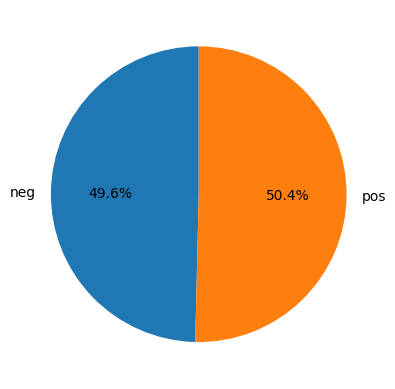

In [3]:
import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews

categ = movie_reviews.categories()
sizes = [len(movie_reviews.sents(categories=x)) for x in categ]

print('Categories:',categ)
print('Sizes:',sizes)

fig,ax=plt.subplots()
ax.pie(sizes, labels=categ, autopct="%.1f%%", startangle=90)

The classes are well balanced.

## Text normalization

In [4]:
# functions to normalize text:
#   1. proper break text in sentences 
#   2. tokenize each word
#   3. downcase each word
#   4. lemmatize it
#   5. make it a text string again
def text_normalization_preprocessor(text: str) -> str:
    return text.lower()
    

## Feature extraction

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features = 30000
feature_extractor = TfidfVectorizer(preprocessor=text_normalization_preprocessor, ngram_range=(1,3), max_features=max_features)#

## Neural network model

In [ ]:
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

from scikeras.wrappers import KerasClassifier

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(
    optimizer='adagrad',
    kernel_initializer='glorot_uniform', 
    dropout=0.2
):
    model = Sequential()
    model.add(Dense(1000, input_dim=max_features, activation='relu',kernel_initializer=kernel_initializer)),
    model.add(Dense(1000,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='tanh', kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# wrap the model using the function you created
keras_sentiment_clf = KerasClassifier(model=create_model,verbose=0)

## Pipeline definition + Model training

In [7]:
# Pipeline definition
from sklearn.pipeline import Pipeline

sentiment_classifier = Pipeline(
    [
        ("features", feature_extractor),
        ("model", keras_sentiment_clf)
    ]
)

In [8]:
# Load dataset
import numpy as np

negdata = [" ".join(x) for x in movie_reviews.sents(categories=['neg'])]
negsize = len(negdata)
posdata = [" ".join(x) for x in movie_reviews.sents(categories=['pos'])]
possize = len(posdata)

X = np.array(negdata + posdata)
y = np.array([-1] * negsize + [1] * possize)

In [9]:
from sklearn.model_selection import train_test_split

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [39]:
history = sentiment_classifier.fit(X_train, y_train, model__epochs=100)
y_pred = sentiment_classifier.predict(X_test)

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

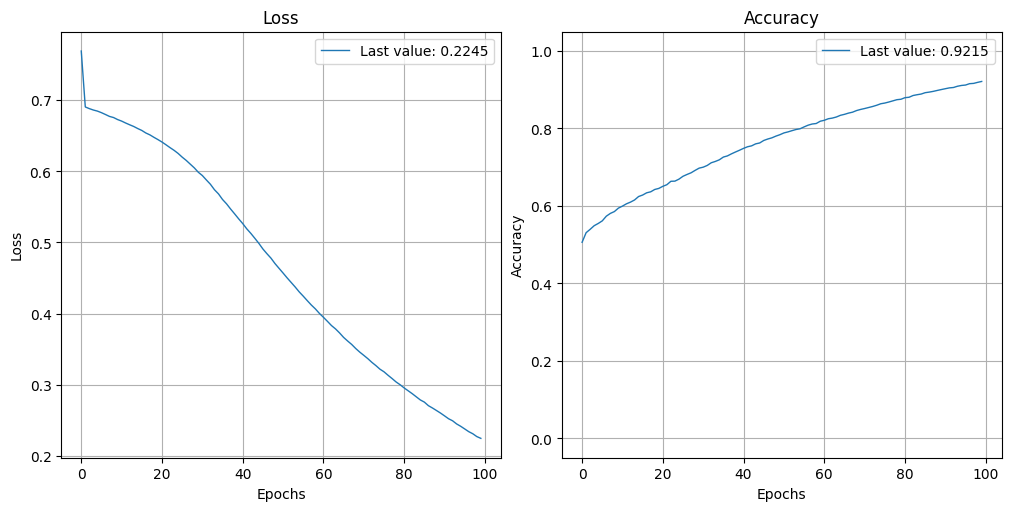

In [40]:
from plot_keras_history import plot_history
plot_history(history._final_estimator.history_)

## Model report

Classification Report: F1[class=1] = 0.661
              precision    recall  f1-score   support

          -1       0.66      0.68      0.67     10720
           1       0.67      0.65      0.66     10740

    accuracy                           0.67     21460
   macro avg       0.67      0.67      0.67     21460
weighted avg       0.67      0.67      0.67     21460

Confusion Matrix:
[[7284 3436]
 [3736 7004]]


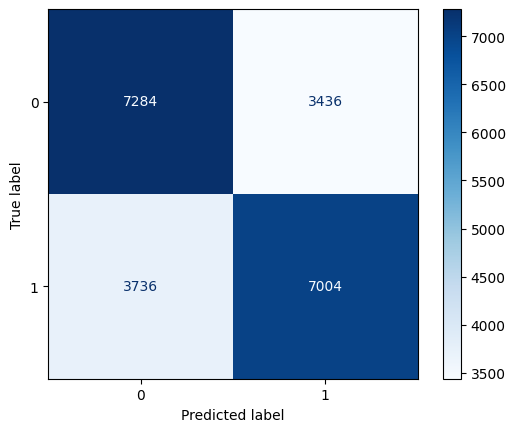

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score


report = classification_report(y_test, y_pred)
f1_score_class1 = f1_score(y_test, y_pred, average=None)
print(f"Classification Report: F1[class=1] = {round(f1_score_class1[1], 3)}")
print(report)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Author Identification from News Articles

## Text normalization

## Feature extraction

## Model report

## Model training